In [1]:
import os
from os import system 
from glob import glob


from math import factorial

import numpy as np

from scipy import integrate
from scipy.special import gamma, gammainc


from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.table import Table
from astropy import stats
from astropy.wcs import WCS
from astropy import utils
from astropy.convolution import convolve_fft
from astropy.stats import sigma_clipped_stats

In [2]:
from dsii_dwarfs.simulate_psf_fit_dwarf_elliptical import SimulatePSFFitDwarfElliptical
from dsii_dwarfs.hsc_patch import HSCPatch, find_hsc_files
from dsii_dwarfs.fit_psf import FitPSF
from dsii_dwarfs.download_hsc_psf import HSC_PSF_DOWNLOADERS

In [3]:
# Matplotlib
# Visualization
import astropy.visualization as vis

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Parameters

In [4]:
# PSF options
psf_options = list(HSC_PSF_DOWNLOADERS.keys())
print(psf_options)

['s16a_deep', 's16a_udeep', 's16a_wide', 'pdr2_udeep', 'pdr2_wide']


In [5]:
# https://hsc-release.mtk.nao.ac.jp username and passowrd
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
#! Reset to empty string after use! !#
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

username = ''
password = ''


# Input Paths
# -----------
# Top level HSC folder path:
hsc_top_path = "" 


# Output and Temp Paths
# ---------------------
# Output path:
output_path = ""

# Temp folder to store temporary files:
temp_path = ""

# Dwarf Params
# -------------
npix = 256 # Must be even
min_number_dward_per_patch = 4
max_number_dward_per_patch = 6

# PSF Params
# ----------
psf_type = 'pdr2_udeep'

# Other Params
# ------------

# Patch padding: sets the margins of where the dwarfs will be placed
# So a patch_padding of 100 pixels will insure all dwarfs will be palced 
# 100 pixels within the HSC patch images.
patch_padding = 256*2 # Pixels

verbose = False

In [6]:
# User must create paths to avoid mistakes
assert os.path.isdir(hsc_top_path)
assert os.path.isdir(output_path)
assert os.path.isdir(temp_path)

# File Base

Find all HSC patch image files and organize them into patchs

In [7]:
patch_dict = find_hsc_files(hsc_top_path)

✓ 9813_1,2
✓ 9813_1,3
✓ 9813_1,4
✓ 9813_2,2
✓ 9813_2,3
✓ 9813_2,4
✓ 9813_3,3
✓ 9813_3,4

Number of Patches:  8




In [8]:
# patch_dict = {'9813_2,2': patch_dict['9813_2,2']}

# Main Loop

In [9]:
def create_plot(plot_data, galaxy_pos, image_output_path, title=""):
        # Create figure and axes
        fig, ax = plt.subplots(1)

        # Display the image
        ax.imshow(plot_data, vmax=0.39, vmin=0, origin='lower',)

        for i, (x,y) in enumerate(galaxy_pos):
            # Create a Rectangle patch
            dx = galaxy_delta_pos[i]
            rect = patches.Rectangle((x-dx//2, y-dx//2),dx,dx,
                                     linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

            # Create a 256 Rectangle patch
            dx = 256
            rect = patches.Rectangle((x-dx//2, y-dx//2),dx,dx,linewidth=0.5,
                                     linestyle="--",edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            
        ax.set_title(title)
        ax.set_xlabel("Pixels")
        ax.set_ylabel("Pixels")
        ax.legend(('Cutout Size', '256 Pix Box'), loc='center left', bbox_to_anchor=(1, 0.5))
        

        plt.show()
        fig.savefig(image_output_path, dpi=600)

In [10]:
def create_catalog(final_path_output_path,
                   galaxy_pos, galaxy_delta_pos, table_output_path):
    catalog = []
    final_path_output_path = os.path.basename(final_path_output_path)
    for i, pos in enumerate(galaxy_pos):
        xcenter, ycenter = pos
        dx = dy = galaxy_delta_pos[i]
        tl = (xcenter+dx//2, ycenter+dy//2)
        tr = (xcenter-dx//2, ycenter+dy//2)
        br = (xcenter-dx//2, ycenter-dy//2)
        bl = (xcenter+dx//2, ycenter-dy//2)
        catalog.append([final_path_output_path, *tl, *tr, *br, *bl, ycenter*naxis2+(naxis2-xcenter)]) #  Last value used for sorting

    catalog_table = Table(np.array(catalog))
    catalog_table.sort(catalog_table.colnames[-1], reverse=True)
    catalog_table.remove_column(catalog_table.colnames[-1])
    catalog_table.write(table_output_path, format="ascii.csv", overwrite=True)

In [11]:
def pick_dwarf_position(num_dwarfs, naxis1, naxis2, patch):
    """Return a list of (x, y) pixel coords of dwarf centers"""
    global patch_padding, npix
    
    assert naxis1-patch_padding > 0
    assert naxis2-patch_padding > 0
    
    galaxy_pos = []
    for i in range(num_dwarfs):
        unique = False
        while not unique:
            x = np.random.randint(patch_padding, naxis1-patch_padding)
            y = np.random.randint(patch_padding, naxis2-patch_padding)
            
            unique = True 
            for xi, yi in galaxy_pos:
                dist = abs(np.linalg.norm(np.array([x, y])-np.array([xi, yi])))
                if dist < npix:
                    unique = False
                    break
                
        galaxy_pos.append((x, y))        
    
    return galaxy_pos

In [12]:
def get_new_sim():
    global verbose, npix 
    print("> sim = SimulatePSFFitDwarfElliptical")
    sim = SimulatePSFFitDwarfElliptical(dmax=15., mf_min=1.e5, mf_max=1.e9, 
                                        npix=npix, oversampling=5, auto_npix=True, 
                                        verbose=verbose)
    
    print("> sim.pick_galaxy")
    sim.pick_galaxy()
    
    return sim

HSC 1 of 8: 9813_1,2
Number of Dwarfs: 5
--------------------------------------------------
Dwarf 1 of 5 9813_1,2_150.81058_1.86471
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 2 of 5 9813_1,2_150.86391_1.89665
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy


/Users/rgeda/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)


npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 3 of 5 9813_1,2_150.77435_1.8531
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 4 of 5 9813_1,2_150.82933_1.92933
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
Very faint dwarf
noise_level = 0.0016,  max_galaxy_flux = 0.0003773411240917856
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create

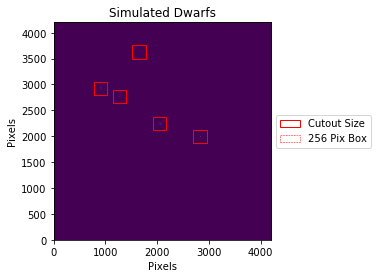

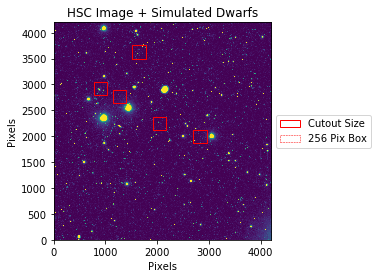

HSC 2 of 8: 9813_1,3
Number of Dwarfs: 5
--------------------------------------------------
Dwarf 1 of 5 9813_1,3_150.78701_1.99294
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
Very faint dwarf
noise_level = 0.0016,  max_galaxy_flux = 0.0003651992786107585
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 2 of 5 9813_1,3_150.78541_2.09411
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
Very faint dwarf
noise_level = 0.0016,  max_galaxy_flux = 0.0002102092861455458
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


-----------------------------------

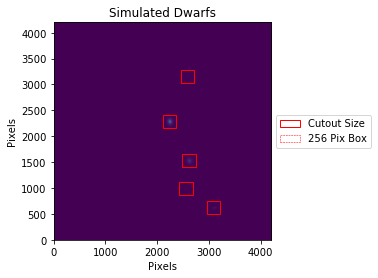

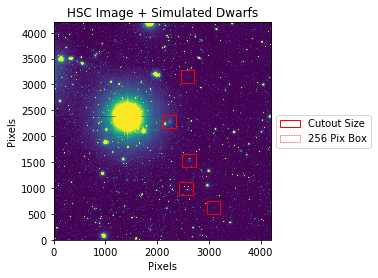

HSC 3 of 8: 9813_1,4
Number of Dwarfs: 5
--------------------------------------------------
Dwarf 1 of 5 9813_1,4_150.79653_2.2426
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 2 of 5 9813_1,4_150.77461_2.18959
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 3 of 5 9813_1,4_150.85737_2.21219
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochro

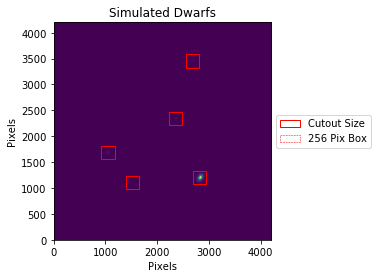

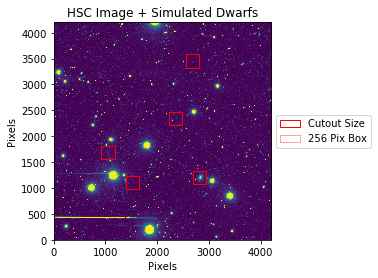

HSC 4 of 8: 9813_2,2
Number of Dwarfs: 6
--------------------------------------------------
Dwarf 1 of 6 9813_2,2_150.65762_1.79424
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
Very faint dwarf
noise_level = 0.0016,  max_galaxy_flux = 0.0015067738458997657
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 2 of 6 9813_2,2_150.62262_1.853
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy


/Users/rgeda/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)


npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 3 of 6 9813_2,2_150.55927_1.90817
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
Very faint dwarf
noise_level = 0.0016,  max_galaxy_flux = 0.0009070277903678744
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 4 of 6 9813_2,2_150.68371_1.79507
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
auto_npix resize 256->262
npix: 262
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.

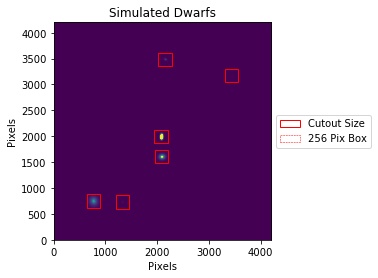

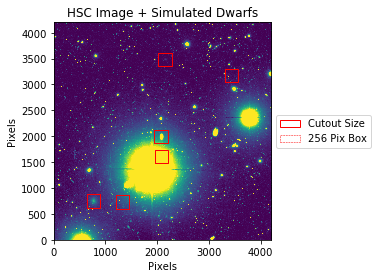

HSC 5 of 8: 9813_2,3
Number of Dwarfs: 4
--------------------------------------------------
Dwarf 1 of 4 9813_2,3_150.57657_2.01997
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 2 of 4 9813_2,3_150.68675_2.10581
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 3 of 4 9813_2,3_150.64141_2.1061
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochro

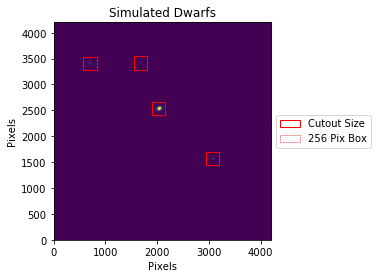

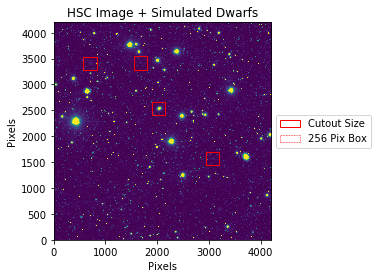

HSC 6 of 8: 9813_2,4
Number of Dwarfs: 5
--------------------------------------------------
Dwarf 1 of 5 9813_2,4_150.57909_2.19044
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
auto_npix resize 256->374
npix: 374
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 2 of 5 9813_2,4_150.58727_2.25456
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 3 of 5 9813_2,4_150.62037_2.18726
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy


/Users/rgeda/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)


npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 4 of 5 9813_2,4_150.6188_2.2707
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 5 of 5 9813_2,4_150.64271_2.25048
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses




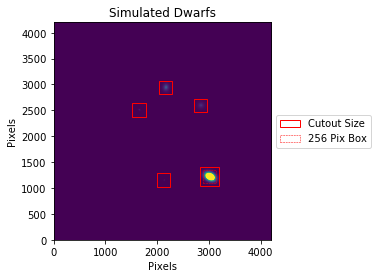

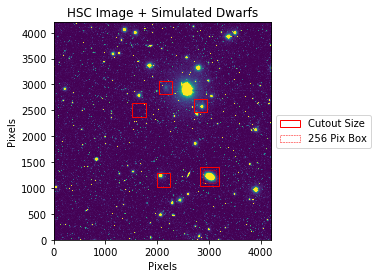

HSC 7 of 8: 9813_3,3
Number of Dwarfs: 4
--------------------------------------------------
Dwarf 1 of 4 9813_3,3_150.47978_2.05686
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 2 of 4 9813_3,3_150.50154_2.07137
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
Very faint dwarf
noise_level = 0.0016,  max_galaxy_flux = 0.0001295345933209984
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 3 of 4 9813_3,3_150.45359_2.08234
> get_new_sim
> sim = Si

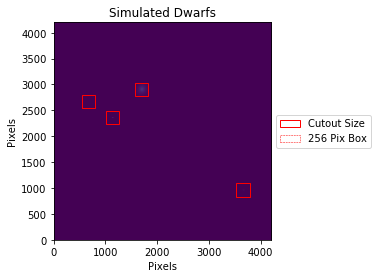

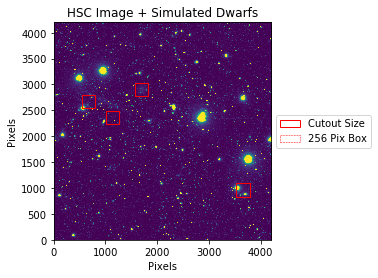

HSC 8 of 8: 9813_3,4
Number of Dwarfs: 6
--------------------------------------------------
Dwarf 1 of 6 9813_3,4_150.47775_2.22261
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
Very faint dwarf
noise_level = 0.0016,  max_galaxy_flux = 0.0007953648264002105
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 2 of 6 9813_3,4_150.41724_2.29836
> get_new_sim
> sim = SimulatePSFFitDwarfElliptical
> sim.pick_galaxy
npix: 256
> sim.renormalize_isochrone
> sim.compute_smooth_flux
> sim.create_smooth_portion
> sim.create_stochastic_portion
> sim.sum_components
> sim.create_psf
> sim.simulate_hsc_image
> sim.save_fits
> loop analyses


--------------------------------------------------
Dwarf 3 of 6 9813_3,4_150.38669_2.28511
> get_new_sim
> sim = Si

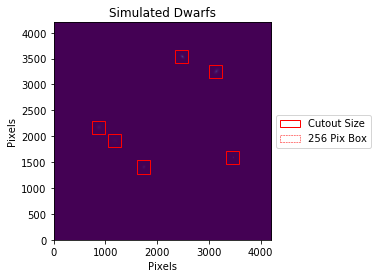

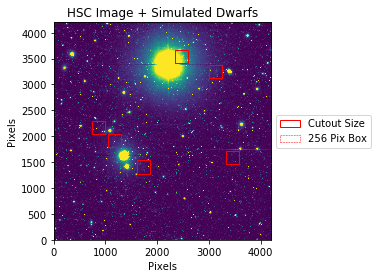

Done


In [13]:
# For each HSC path
for count, name in enumerate(patch_dict):
    print("="*50)
    print("HSC {} of {}: {}".format(count+1, len(patch_dict), name))

    catalog = []
       
    # Set basic params for this patch
    patch = patch_dict[name]
    num_dwarfs = np.random.randint(min_number_dward_per_patch, max_number_dward_per_patch+1)
    print("Number of Dwarfs:", num_dwarfs)
    
    # Load WCS
    header = fits.getheader(patch.g, ext=1)
    naxis1 = header["NAXIS1"]
    naxis2 = header["NAXIS2"]
    w = WCS(header)
    
    # Generate positions
    galaxy_pos = pick_dwarf_position(num_dwarfs, naxis1, naxis2, patch)
    galaxy_radec = w.all_pix2world(galaxy_pos,0)
    galaxy_delta_pos = []
    
    # Create output image
    output_patch_data = np.zeros( (5, naxis2, naxis1) )
    for i, (band, patch_path) in enumerate(patch.bands.items()):
        output_patch_data[i] = fits.getdata(patch_path)

    for dwarf_index, pos in enumerate(galaxy_radec):
        print("-"*50)
        
        ra, dec = np.round(pos[0], 5), np.round(pos[1], 5)
        dwarf_name = "{}_{}_{}".format(name, ra, dec)
        
        print("Dwarf {} of {}".format(dwarf_index+1, len(galaxy_radec)), dwarf_name)
        
        print("> get_new_sim")
        sim = get_new_sim()
        
        print("npix:", sim.npix)
        if sim.verbose:
            print("mass: ",np.log10(sim.mass))
            print("distance: ",sim.distance)
            print("re_kpc, arcsec, pix: ",sim.re_kpc, sim.re_arcsec, sim.re_pixels)
            print("[Fe/H]: ",sim.feh)
            print("age: ",sim.age)
            print("ellip: ",sim.ellipticity)
            print("pa: ",sim.position_angle)
            print("")

        print("> sim.renormalize_isochrone")
        sim.renormalize_isochrone()

        print("> sim.compute_smooth_flux")
        sim.compute_smooth_flux()

        print("> sim.create_smooth_portion")
        sim.create_smooth_portion()
        
        print("> sim.create_stochastic_portion")
        #sim.create_stochastic_portion()
        
        print("> sim.sum_components")
        #sim.sum_components()

        print("> sim.create_psf")
        sim.create_psf(
            psf_type=psf_type,
            ra=ra, dec=dec, 
            band=band, 
            patch=patch, 
            output_path=temp_path, 
            username=username, 
            password=password)
        
        print("> sim.simulate_hsc_image")
        sim.simulate_hsc_image()

        print("> sim.save_fits")
        noiseless_file = sim.save_fits(output_path, noiseless_only=True)[0]
        
        print("> loop analyses")
        dwarf_data = fits.getdata(noiseless_file)
        
        xcenter, ycenter = galaxy_pos[dwarf_index]
        dx, dy = dwarf_data[0].shape
        
        galaxy_delta_pos.append(dx)
        
        for i, (band, patch_path) in enumerate(patch.bands.items()):
            output_patch_data[i, ycenter-dy//2:ycenter+dy//2, xcenter-dx//2:xcenter+dx//2] += dwarf_data[i]      

        print("\n")
        
        
    output_name = "hsc_dwarf_sim_{}".format(patch.name)
    
    final_path_output_path = os.path.join(output_path, output_name+".fits")
    fits.HDUList([fits.PrimaryHDU(data=output_patch_data, header=w.to_header())]).writeto(final_path_output_path, overwrite=True)
    
    # Output Images 
    # -------------
    # Dwarfs only
    image_output_path = os.path.join(output_path, output_name+"_dwarfs_only.png")
    create_plot(output_patch_data[0]-fits.getdata(patch.g), galaxy_pos, image_output_path, "Simulated Dwarfs")
    
    # HSC + Dwarfs
    image_output_path = os.path.join(output_path, output_name+".png".format(patch.name))
    create_plot(output_patch_data[0], galaxy_pos, image_output_path, "HSC Image + Simulated Dwarfs")


    # Output Catalogs
    # ---------------
    # Exact 
    table_output_path = os.path.join(output_path, output_name+"_exact.csv".format(patch.name))
    create_catalog(final_path_output_path, 
                   galaxy_pos, galaxy_delta_pos, table_output_path)
    
    # 256
    array_256 = [256 for i in galaxy_delta_pos]
    table_output_path = os.path.join(output_path, output_name+"_256.csv".format(patch.name))
    create_catalog(final_path_output_path, 
                   galaxy_pos, array_256, table_output_path)


print("Done")

# Zip Up Results

In [14]:
cwd = os.getcwd()
os.chdir(output_path)

# Zip all files
for count, name in enumerate(patch_dict):
    print(count+1, "of", len(patch_dict), name)
    patch = patch_dict[name]
    tar_path = "hsc_dwarf_sim_{}".format(patch.name)#os.path.join(output_path, "hsc_dwarf_sim_{}".format(patch.name))
    print(os.system("tar -cvzf {}.tar.gz {}*".format(tar_path, tar_path, output_path)))
    
os.chdir(cwd)
print("Done")

1 of 8 9813_1,2
0
2 of 8 9813_1,3
0
3 of 8 9813_1,4
0
4 of 8 9813_2,2
0
5 of 8 9813_2,3
0
6 of 8 9813_2,4
0
7 of 8 9813_3,3
0
8 of 8 9813_3,4
0
Done


# Scrap

In [ ]:
def observed_cts_per_sec(isochrone_flux,lumdist,zpt=27.0):
    zptflux = 10.**(zpt/2.5)
    distratio = lumdist *1.e6/10.  # lumdist is in Mpc, isochrone is computed for 10 parsecs
    return isochrone_flux*zptflux/distratio**2

In [24]:
patch_dict

{'9813_2,2': <dsii_dwarfs.hsc_patch.HSCPatch at 0x11e514390>}

In [25]:
p = patch_dict['9813_2,2']

In [26]:
z_data = fits.getdata(p.z)

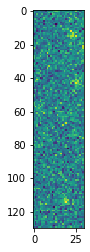

In [39]:
plt.imshow(z_data[20:150, 20:50])

In [44]:
std = sigma_clipped_stats(z_data[20:150, 20:50])
std

(0.019808951765298843, 0.019781969487667084, 0.019397377967834473)

In [43]:
std = sigma_clipped_stats(z_data)
std

(0.021523822098970413, 0.014940600842237473, 0.03265238180756569)

In [25]:
0.04/(25)

0.0016